In [5]:
from os.path import samefile
# unzip data

!unzip ./sample_data/archive.zip -d cat_dog_data

Streaming output truncated to the last 5000 lines.
  inflating: cat_dog_data/training_set/training_set/cats/cat.3704.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3705.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3706.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3707.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3708.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3709.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.371.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3710.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3711.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3712.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3713.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3714.jpg  
  inflating: cat_dog_data/training_set/training_set/cats/cat.3715.jpg  
  inflating: c

In [6]:
import torch
import torchvision
from  torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
])
#train data
train_data = datasets.ImageFolder('cat_dog_data/training_set/training_set', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test data
test_data = datasets.ImageFolder('cat_dog_data/test_set/test_set', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

class_names = train_data.classes

for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0])


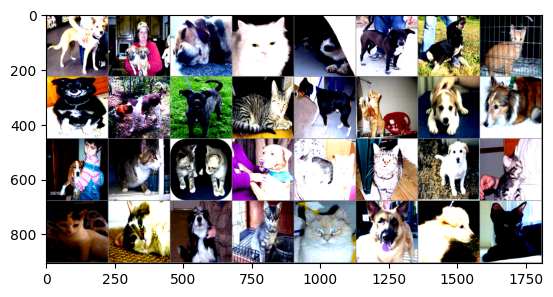

 dogs  dogs  dogs  cats  dogs  dogs  dogs  cats  dogs  dogs  dogs  cats  dogs  cats  dogs  dogs  dogs  cats  cats  dogs  cats  cats  dogs  cats  cats  cats  dogs  cats  cats  dogs  dogs  cats


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % class_names[labels[j]] for j in range(32)))

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [20]:
from torchsummary import summary
model = net.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 5,407,286
Trainable params: 5,407,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.63
Estimated Total Size (MB): 25.69
----------------------------------------------------------------


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [120]:
def calculate_metrics(model, loader):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [129]:
def train_model(criterion, optimizer, batch_size, num_epochs):

  train_loss_list = []
  train_accuracy_list = []
  model = Net()

  for epoch in range(5):
      running_logg = 0.0
      for idx, data in enumerate(train_loader, 0):
          inputs, labels = data

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_logg += loss.item()


          if idx % 2000 == 1999:
              print(f'[{epoch+1}, {idx+1:5d}] loss: {running_logg/2000:.3f}')
              running_logg = 0.0
      train_loss, train_accuracy = calculate_metrics(model, train_loader)
      train_loss_list.append(train_loss)
      train_accuracy_list.append(train_accuracy)
      return train_loss_list, train_accuracy_list, model


In [27]:
import itertools

# Define hyperparameters and their search space
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
optimizers = [optim.SGD, optim.Adam, optim.Adagrad]
num_epochs = [5]

# Dictionary to store performance metrics for each hyperparameter combination
hyperparameter_metrics = {}

# Perform grid search
for lr, batch_size, optimizer_cls, num_epoch in itertools.product(learning_rates, batch_sizes, optimizers, num_epochs):
    optimizer = optimizer_cls(net.parameters(), lr=lr)

    train_loss_list, train_accuracy_list = train_model(criterion, optimizer, batch_size, num_epoch)

    # Evaluate model performance using validation set
    validation_loss, validation_accuracy = calculate_metrics(test_loader)

    # Store performance metrics for this hyperparameter combination
    hyperparameter_metrics[(lr, batch_size, optimizer_cls, num_epoch)] = {
        'train_loss_list': train_loss_list,
        'train_accuracy_list': train_accuracy_list,
        'validation_loss': validation_loss,
        'validation_accuracy': validation_accuracy
    }

# Choose best hyperparameters based on validation accuracy
best_hyperparameters = max(hyperparameter_metrics, key=lambda k: hyperparameter_metrics[k]['validation_accuracy'])
best_performance_metrics = hyperparameter_metrics[best_hyperparameters]

print("Best Hyperparameters:", best_hyperparameters)
print("Best Performance Metrics:", best_performance_metrics)


Best Hyperparameters: (0.001, 64, <class 'torch.optim.sgd.SGD'>, 5)
Best Performance Metrics: {'train_loss_list': [0.2540884212371838], 'train_accuracy_list': [0.8946908182386009], 'validation_loss': 0.6355301639996469, 'validation_accuracy': 0.7439446366782007}


In [49]:
# Import pandas for tabular formatting
import pandas as pd
from IPython.display import display
# Convert the dictionary to a DataFrame for tabular formatting
df = pd.DataFrame.from_dict(hyperparameter_metrics, orient='index')

# Display the DataFrame

df.head(100)
new_column_names = {
    "train_loss_list": "Train Loss",
    "train_accuracy_list": "Accuracy",
    "validation_loss": "Validation Loss",
    "validation_accuracy": "Validation Accuracy"
}
df = df.rename(columns=new_column_names)
df.info()
df.describe()
df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27 entries, (0.001, 16, <class 'torch.optim.sgd.SGD'>, 5) to (0.1, 64, <class 'torch.optim.adagrad.Adagrad'>, 5)
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Train Loss           27 non-null     object 
 1   Accuracy             27 non-null     object 
 2   Validation Loss      27 non-null     float64
 3   Validation Accuracy  27 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.5+ KB


Train Loss  \
0.001 16 <class 'torch.optim.sgd.SGD'>         5   [0.8437319866927021]   
         <class 'torch.optim.adam.Adam'>       5   [0.5658767940513642]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.4498797959659204]   
      32 <class 'torch.optim.sgd.SGD'>         5   [0.4273418619694463]   
         <class 'torch.optim.adam.Adam'>       5    [0.368358109042464]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.2605512298020234]   
      64 <class 'torch.optim.sgd.SGD'>         5   [0.2540884212371838]   
         <class 'torch.optim.adam.Adam'>       5  [0.21178505442056997]   
         <class 'torch.optim.adagrad.Adagrad'> 5  [0.08818907141537068]   
0.010 16 <class 'torch.optim.sgd.SGD'>         5    [0.640798474331776]   
         <class 'torch.optim.adam.Adam'>       5    [0.694177007295221]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.5671056340415165]   
      32 <class 'torch.optim.sgd.SGD'>         5    [0.549486036438391]   
         <class 'torch.optim.adam.Adam'>       5   [0.6904150043350766]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6219876996312008]   
      64 <class 'torch.optim.sgd.SGD'>         5   [0.6193676664534793]   
         <class 'torch.optim.adam.Adam'>       5   [0.6462233793213072]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6230336669906676]   
0.100 16 <class 'torch.optim.sgd.SGD'>         5   [0.6657707235252714]   
         <class 'torch.optim.adam.Adam'>       5   [0.6934856506457842]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6984694723589012]   
      32 <class 'torch.optim.sgd.SGD'>         5   [0.6971551346113958]   
         <class 'torch.optim.adam.Adam'>       5   [0.6954996277136631]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6934381673535502]   
      64 <class 'torch.optim.sgd.SGD'>         5   [0.6931638584668893]   
         <class 'torch.optim.adam.Adam'>       5   [0.7015043157505324]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6938539327853229]   

                                                               Accuracy  \
0.001 16 <class 'torch.optim.sgd.SGD'>         5   [0.5003123048094941]   
         <class 'torch.optim.adam.Adam'>       5   [0.7105559025608994]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.7871330418488445]   
      32 <class 'torch.optim.sgd.SGD'>         5   [0.8036227357901312]   
         <class 'torch.optim.adam.Adam'>       5   [0.8507183010618363]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.8964397251717676]   
      64 <class 'torch.optim.sgd.SGD'>         5   [0.8946908182386009]   
         <class 'torch.optim.adam.Adam'>       5   [0.9331667707682698]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.9737663960024985]   
0.010 16 <class 'torch.optim.sgd.SGD'>         5   [0.7427857589006871]   
         <class 'torch.optim.adam.Adam'>       5   [0.6244846970643347]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.7024359775140537]   
      32 <class 'torch.optim.sgd.SGD'>         5   [0.7206745783885072]   
         <class 'torch.optim.adam.Adam'>       5    [0.524422236102436]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6433479075577764]   
      64 <class 'torch.optim.sgd.SGD'>         5   [0.6455965021861336]   
         <class 'torch.optim.adam.Adam'>       5   [0.6012492192379763]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.6277326670830731]   
0.100 16 <class 'torch.optim.sgd.SGD'>         5   [0.5580262336039975]   
         <class 'torch.optim.adam.Adam'>       5   [0.4998126171143036]   
         <class 'torch.optim.adagrad.Adagrad'> 5   [0.5003123048094941]   
      32 <class 'torch.optim.sgd.SGD'>         5   [0.5003123048094941]   
         <class 'torch.optim.adam.Adam'>       5  [0.49968769519050593]   
         <class 'torch.optim.adagrad.Adagrad'> 5  [0.49968769519050593]   
      64 <class 'torch.optim.sgd.SGD'>         5  [0.49968769519050593]   
         <

In [124]:
for index, row in df.iterrows():
    # Get the optimizer object
    optimizer_obj = index[2]  # Assuming optimizer is the third level of the MultiIndex
    print(optimizer_obj.__name__)
    # Get the class name of the optimizer
    optimizer_class = optimizer_obj.__name__

    # Map the class name to plain English name

    if optimizer_class == 'SGD':
        optimizer_name = 'Stochastic Gradient Descent'
    elif optimizer_class == 'Adam':
        optimizer_name = 'Adam'
    elif optimizer_class == 'Adagrad':
        optimizer_name = 'Adagrad'
    else:
        optimizer_name = 'Unknown'

    # Update the optimizer information in the DataFrame
    df.at[index, ('Optimizer')] = optimizer_name

SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad
SGD
Hello
Adam
Adagrad


In [83]:
for index, row in df.iterrows():
  learning_rate = index[0]
  batch_size = index[1]
  df.at[index, ("Learning Rate")] = learning_rate
  df.at[index, ("Batch Size")] = batch_size

In [84]:

df

Train Loss              Accuracy         Validation Loss  Validation Accuracy          Optimizer            Learning Rate  Batch Size
Learning Rate Batch Size Optimizer                             Epoch                                                                                                                                            
1.00e-03      16         <class 'torch.optim.sgd.SGD'>         5       [0.8437319866927021]   [0.5003123048094941]       0.85               0.50          Stochastic Gradient Descent    1.00e-03        16.0   
                         <class 'torch.optim.adam.Adam'>       5       [0.5658767940513642]   [0.7105559025608994]       0.64               0.67                                 Adam    1.00e-03        16.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5       [0.4498797959659204]   [0.7871330418488445]       0.56               0.72                              Adagrad    1.00e-03        16.0   
              32         <class 'torch.optim.sgd.SGD'>         5       [0.4273418619694463]   [0.8036227357901312]       0.56               0.73          Stochastic Gradient Descent    1.00e-03        32.0   
                         <class 'torch.optim.adam.Adam'>       5        [0.368358109042464]   [0.8507183010618363]       0.55               0.72                                 Adam    1.00e-03        32.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5       [0.2605512298020234]   [0.8964397251717676]       0.60               0.74                              Adagrad    1.00e-03        32.0   
              64         <class 'torch.optim.sgd.SGD'>         5       [0.2540884212371838]   [0.8946908182386009]       0.64               0.74          Stochastic Gradient Descent    1.00e-03        64.0   
                         <class 'torch.optim.adam.Adam'>       5      [0.21178505442056997]   [0.9331667707682698]       0.63               0.71                                 Adam    1.00e-03        64.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5      [0.08818907141537068]   [0.9737663960024985]       0.83               0.72                              Adagrad    1.00e-03        64.0   
1.00e-02      16         <class 'torch.optim.sgd.SGD'>         5        [0.640798474331776]   [0.7427857589006871]       1.18               0.61          Stochastic Gradient Descent    1.00e-02        16.0   
                         <class 'torch.optim.adam.Adam'>       5        [0.694177007295221]   [0.6244846970643347]       0.72               0.60                                 Adam    1.00e-02        16.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5       [0.5671056340415165]   [0.7024359775140537]       0.66               0.62                              Adagrad    1.00e-02        16.0   
              32         <class 'torch.optim.sgd.SGD'>         5        [0.549486036438391]   [0.7206745783885072]       0.69               0.63          Stochastic Gradient Descent    1.00e-02        32.0   
                         <class 'torch.optim.adam.Adam'>       5       [0.6904150043350766]    [0.524422236102436]       0.69               0.52                                 Adam    1.00e-02        32.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5       [0.6219876996312008]   [0.6433479075577764]       0.65               0.61                              Adagrad    1.00e-02        32.0   
              64         <class 'torch.optim.sgd.SGD'>         5       [0.6193676664534793]   [0.6455965021861336]       0.66               0.61          Stochastic Gradient Descent    1.00e-02        64.0   
                         <class 'torch.optim.adam.Adam'>       5       [0.6462233793213072]   [0.6012492192379763]       0.67               0.58                                 Adam    1.00e-02        64.0   
                         <class 'torch.optim.adagrad.Adagrad'> 5       [0.6230336669906676]   [0.6277326

In [114]:
column_order = ["Learning Rate", "Batch Size", "Optimizer", "Accuracy", "Train Loss", "Validation Accuracy", "Validation Loss"]
from tabulate import tabulate


headers = df.columns.tolist()

# Display the table using tabulate
table = tabulate(df[column_order], headers='keys', tablefmt='plain')
print(table)

file_path = 'hyperparameter_metrics.xlsx'
df[column_order].to_excel(file_path, index=False)
print(f"Excel file saved here: ", file_path)

                                                         Learning Rate    Batch Size  Optimizer                    Accuracy               Train Loss               Validation Accuracy    Validation Loss
(0.001, 16, <class 'torch.optim.sgd.SGD'>, 5)                    0.001            16  Stochastic Gradient Descent  [0.5003123048094941]   [0.8437319866927021]                0.500247           0.848175
(0.001, 16, <class 'torch.optim.adam.Adam'>, 5)                  0.001            16  Adam                         [0.7105559025608994]   [0.5658767940513642]                0.667326           0.643861
(0.001, 16, <class 'torch.optim.adagrad.Adagrad'>, 5)            0.001            16  Adagrad                      [0.7871330418488445]   [0.4498797959659204]                0.723678           0.562071
(0.001, 32, <class 'torch.optim.sgd.SGD'>, 5)                    0.001            32  Stochastic Gradient Descent  [0.8036227357901312]   [0.4273418619694463]                0.726644          

In [ ]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics')
plt.legend()
plt.show()

In [130]:
import itertools

# Define hyperparameters and their search space
learning_rates = 0.001
batch_sizes = 64
num_epochs = [5, 10, 15, 20, 25, 30]

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Perform grid search
best_accuracy = 0.0
best_hyperparameters = {}

for num_epoch in num_epochs:

    # Train model with current hyperparameters
    print("lr :", lr, "batch_size :", batch_size, "num_epoch :", num_epoch)
    optimizer = optimizer_cls(net.parameters(), lr=learning_rate)

    train_loss, train_accuracy, model = train_model(criterion, optimizer, batch_size, num_epoch)

    # Evaluate model on validation set
    val_average_loss, val_accuracy = calculate_metrics(model, train_loader)

    # Check if current model is better than previous best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size, 'num_epochs': num_epochs,
                                'train_accuacy': train_accuracy, 'train_loss': train_loss,
                                'validation_accuracy': val_accuracy, 'validation_average_loss': val_average_loss}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)

# Train final model with best hyperparameters on full training set
final_model = train_model(best_hyperparameters['learning_rate'], best_hyperparameters['batch_size'], best_hyperparameters['num_epochs'])


lr : 0.001 batch_size : 64 num_epoch : 5
lr : 0.001 batch_size : 64 num_epoch : 10
lr : 0.001 batch_size : 64 num_epoch : 15
lr : 0.001 batch_size : 64 num_epoch : 20
lr : 0.001 batch_size : 64 num_epoch : 25
lr : 0.001 batch_size : 64 num_epoch : 30
Best Hyperparameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': [5, 10, 15, 20, 25, 30], 'train_accuacy': [0.38975640224859465], 'train_loss': [2.277049218515951], 'validation_accuracy': 0.38975640224859465, 'validation_average_loss': 2.276942797391063}
Best Validation Accuracy: 0.38975640224859465


TypeError: train_model() missing 1 required positional argument: 'num_epochs'

In [131]:
print(best_hyperparameters)

{'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': [5, 10, 15, 20, 25, 30], 'train_accuacy': [0.38975640224859465], 'train_loss': [2.277049218515951], 'validation_accuracy': 0.38975640224859465, 'validation_average_loss': 2.276942797391063}


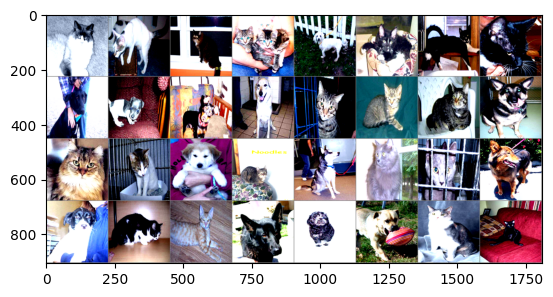

 cats  cats  cats  cats  dogs  cats  cats  cats  dogs  dogs  dogs  dogs  cats  cats  cats  dogs  cats  cats  dogs  cats  dogs  cats  cats  dogs  dogs  cats  cats  dogs  dogs  dogs  cats  cats


In [132]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % class_names[labels[j]] for j in range(32)))